In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Load the dataset
ev_data = pd.read_csv('Electric_Vehicle_Population_Data.csv')  # Load dataset

# Display the first few rows to understand structure and content
print("First 5 rows of the dataset:")
print(ev_data.head(), "\n")

# Basic dataset information
print("Dataset Info:")
print(ev_data.info(), "\n")

# Check for missing values
print("Missing Values in Each Column:")
print(ev_data.isnull().sum(), "\n")

# Display summary statistics for numeric columns
print("Summary Statistics:")
print(ev_data.describe(), "\n")

# Check for and remove duplicate rows to ensure data quality
initial_rows = ev_data.shape[0]
ev_data.drop_duplicates(inplace=True)
print(f"Number of rows after removing duplicates: {ev_data.shape[0]} (Removed {initial_rows - ev_data.shape[0]} duplicates)")


First 5 rows of the dataset:
   VIN (1-10)     County       City State  Postal Code  Model Year   Make  \
0  5YJYGDEE1L       King    Seattle    WA      98122.0        2020  TESLA   
1  7SAYGDEE9P  Snohomish    Bothell    WA      98021.0        2023  TESLA   
2  5YJSA1E4XK       King    Seattle    WA      98109.0        2019  TESLA   
3  5YJSA1E27G       King   Issaquah    WA      98027.0        2016  TESLA   
4  5YJYGDEE5M     Kitsap  Suquamish    WA      98392.0        2021  TESLA   

     Model           Electric Vehicle Type  \
0  MODEL Y  Battery Electric Vehicle (BEV)   
1  MODEL Y  Battery Electric Vehicle (BEV)   
2  MODEL S  Battery Electric Vehicle (BEV)   
3  MODEL S  Battery Electric Vehicle (BEV)   
4  MODEL Y  Battery Electric Vehicle (BEV)   

   Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0            Clean Alternative Fuel Vehicle Eligible             291   
1  Eligibility unknown as battery range has not b...               0   
2            Cl

In [2]:
ev_data = ev_data.dropna() #deleting rows with empty fields
print(ev_data) #printing clean version

        VIN (1-10)     County           City State  Postal Code  Model Year  \
0       5YJYGDEE1L       King        Seattle    WA      98122.0        2020   
1       7SAYGDEE9P  Snohomish        Bothell    WA      98021.0        2023   
2       5YJSA1E4XK       King        Seattle    WA      98109.0        2019   
3       5YJSA1E27G       King       Issaquah    WA      98027.0        2016   
4       5YJYGDEE5M     Kitsap      Suquamish    WA      98392.0        2021   
...            ...        ...            ...   ...          ...         ...   
177861  7SAYGDEE3N     Pierce    Bonney Lake    WA      98391.0        2022   
177862  KM8K23AG1P      Mason        Shelton    WA      98584.0        2023   
177863  5YJYGDEE6M      Grant         Quincy    WA      98848.0        2021   
177864  WVGKMPE27M       King  Black Diamond    WA      98010.0        2021   
177865  5YJ3E1EA8M     Pierce         Tacoma    WA      98422.0        2021   

              Make          Model           Electri

/tmp/ipykernel_23341/2148276991.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ev_adoption_by_year.index, y=ev_adoption_by_year.values, palette="viridis")


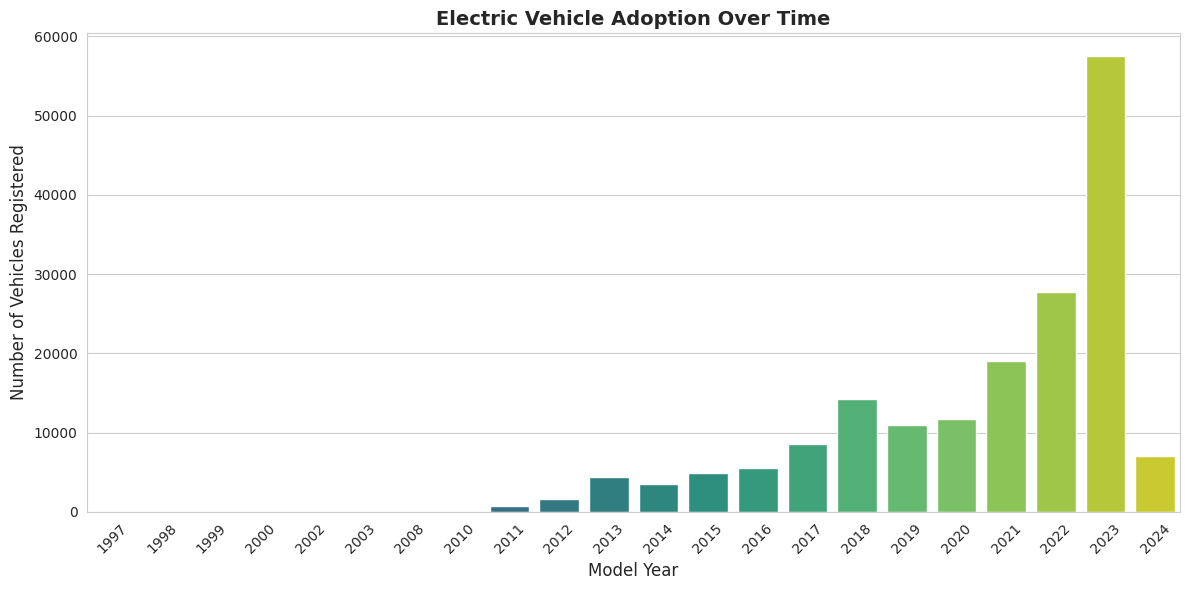

In [3]:
# Set the visualization style
sns.set_style("whitegrid")

# Check for 'Model Year' column and ensure it contains data
if 'Model Year' in ev_data.columns and not ev_data['Model Year'].isnull().all():
    # Prepare data for visualization
    ev_adoption_by_year = ev_data['Model Year'].value_counts().sort_index()
    
    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=ev_adoption_by_year.index, y=ev_adoption_by_year.values, palette="viridis")
    
    # Add titles and labels
    plt.title('Electric Vehicle Adoption Over Time', fontsize=14, weight='bold')
    plt.xlabel('Model Year', fontsize=12)
    plt.ylabel('Number of Vehicles Registered', fontsize=12)
    plt.xticks(rotation=45)
    
    # Adjust layout for readability
    plt.tight_layout()
    plt.show()
else:
    print("The 'Model Year' column is missing or contains no data.")

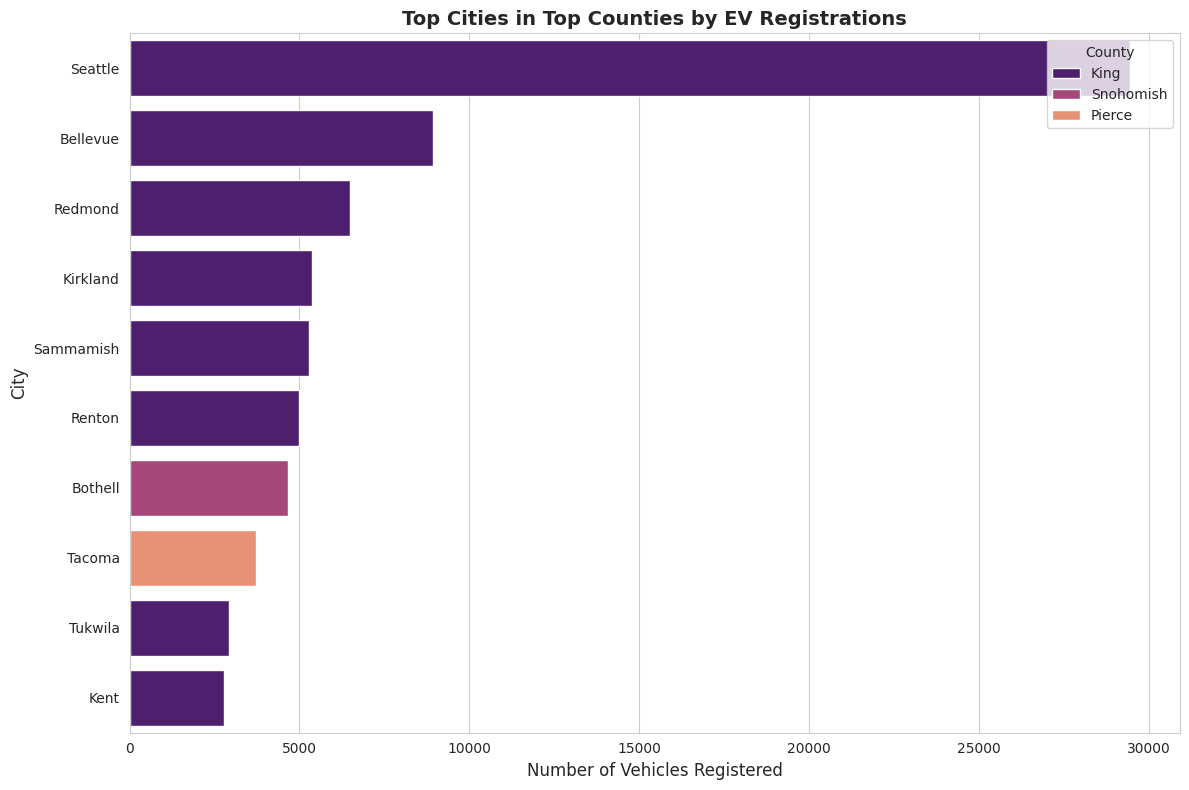

In [4]:
# Check if 'County' and 'City' columns are present and contain data
if 'County' in ev_data.columns and 'City' in ev_data.columns:
    # Get the distribution of EV registrations by county
    ev_county_distribution = ev_data['County'].value_counts()
    
    # Select the top 3 counties with the highest EV registrations
    top_counties = ev_county_distribution.head(3).index
    top_counties_data = ev_data[ev_data['County'].isin(top_counties)]
    
    # Analyze distribution within cities in the top counties
    ev_city_distribution_top_counties = (top_counties_data.groupby(['County', 'City'])
                                        .size()
                                        .sort_values(ascending=False)
                                        .reset_index(name='Number of Vehicles'))
    
    # Select the top 10 cities for visualization
    top_cities = ev_city_distribution_top_counties.head(10)
    
    # Set up the plot for the top cities in the top counties
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Number of Vehicles', y='City', hue='County', data=top_cities, palette="magma")
    
    # Add title and labels
    plt.title('Top Cities in Top Counties by EV Registrations', fontsize=14, weight='bold')
    plt.xlabel('Number of Vehicles Registered', fontsize=12)
    plt.ylabel('City', fontsize=12)
    
    # Customize legend and layout
    plt.legend(title='County', loc='upper right')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'County' and 'City' are missing or contain no data.")


/tmp/ipykernel_23341/2000093113.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ev_type_distribution.values, y=ev_type_distribution.index, palette="rocket")


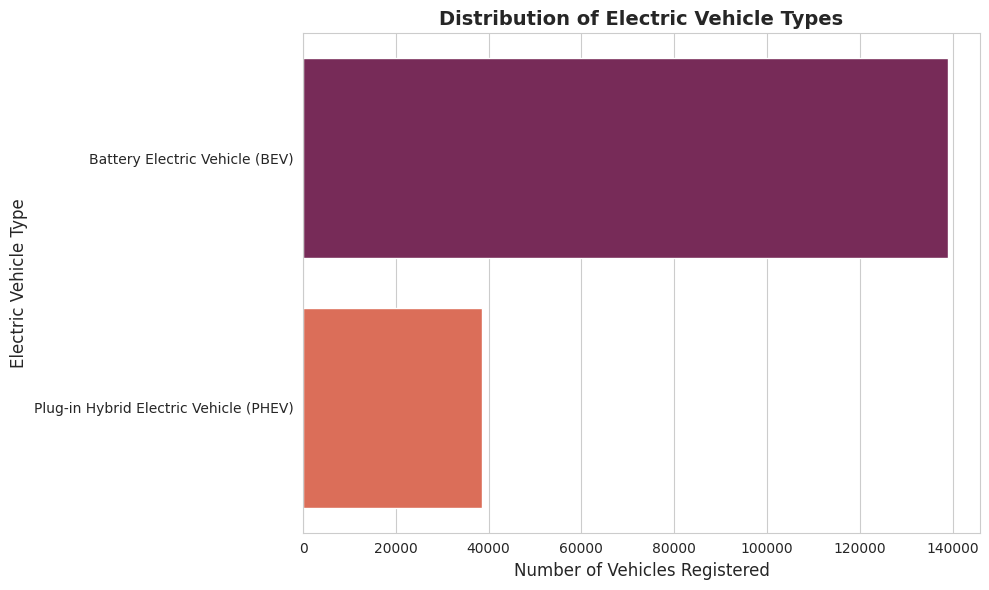

In [5]:
# Check if 'Electric Vehicle Type' column exists and contains data
if 'Electric Vehicle Type' in ev_data.columns and not ev_data['Electric Vehicle Type'].isnull().all():
    # Get the distribution of electric vehicle types
    ev_type_distribution = ev_data['Electric Vehicle Type'].value_counts()
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=ev_type_distribution.values, y=ev_type_distribution.index, palette="rocket")
    
    # Add title and labels
    plt.title('Distribution of Electric Vehicle Types', fontsize=14, weight='bold')
    plt.xlabel('Number of Vehicles Registered', fontsize=12)
    plt.ylabel('Electric Vehicle Type', fontsize=12)
    
    # Adjust layout for better readability
    plt.tight_layout()
    plt.show()
else:
    print("The 'Electric Vehicle Type' column is missing or contains no data.")


/tmp/ipykernel_23341/3254258363.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ev_make_distribution.values, y=ev_make_distribution.index, palette="cubehelix")


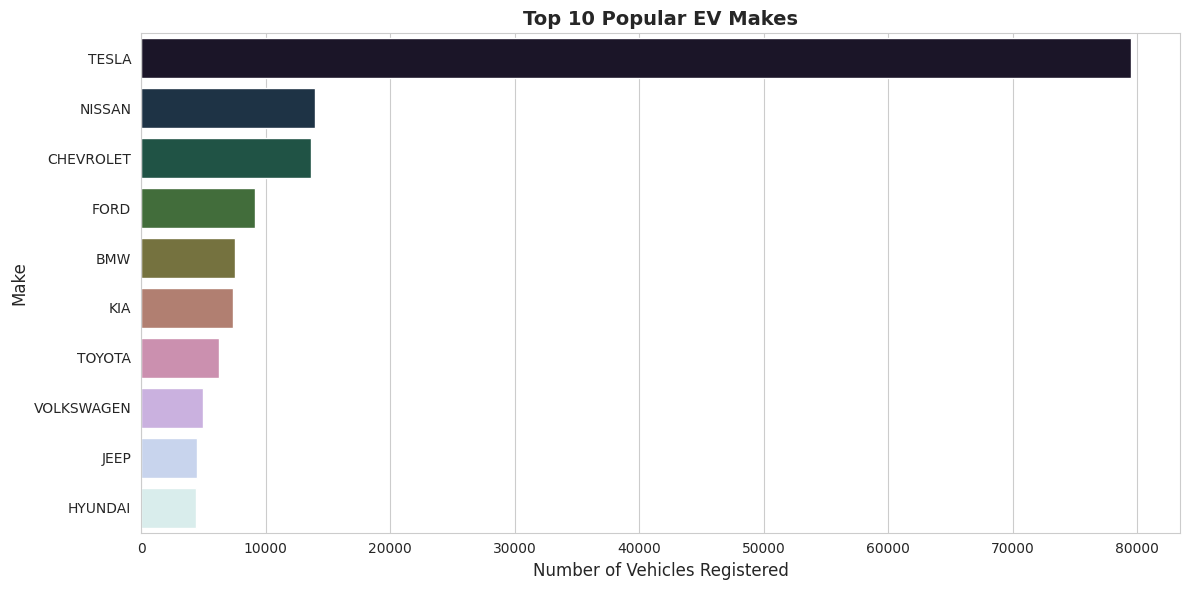

In [6]:
# Check if 'Make' column exists and contains data
if 'Make' in ev_data.columns and not ev_data['Make'].isnull().all():
    # Get the distribution of EV manufacturers and limit to top 10
    ev_make_distribution = ev_data['Make'].value_counts().head(10)
    
    # Set up the plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=ev_make_distribution.values, y=ev_make_distribution.index, palette="cubehelix")
    
    # Add title and labels with improved formatting
    plt.title('Top 10 Popular EV Makes', fontsize=14, weight='bold')
    plt.xlabel('Number of Vehicles Registered', fontsize=12)
    plt.ylabel('Make', fontsize=12)
    
    # Adjust layout for readability
    plt.tight_layout()
    plt.show()
else:
    print("The 'Make' column is missing or contains no data.")

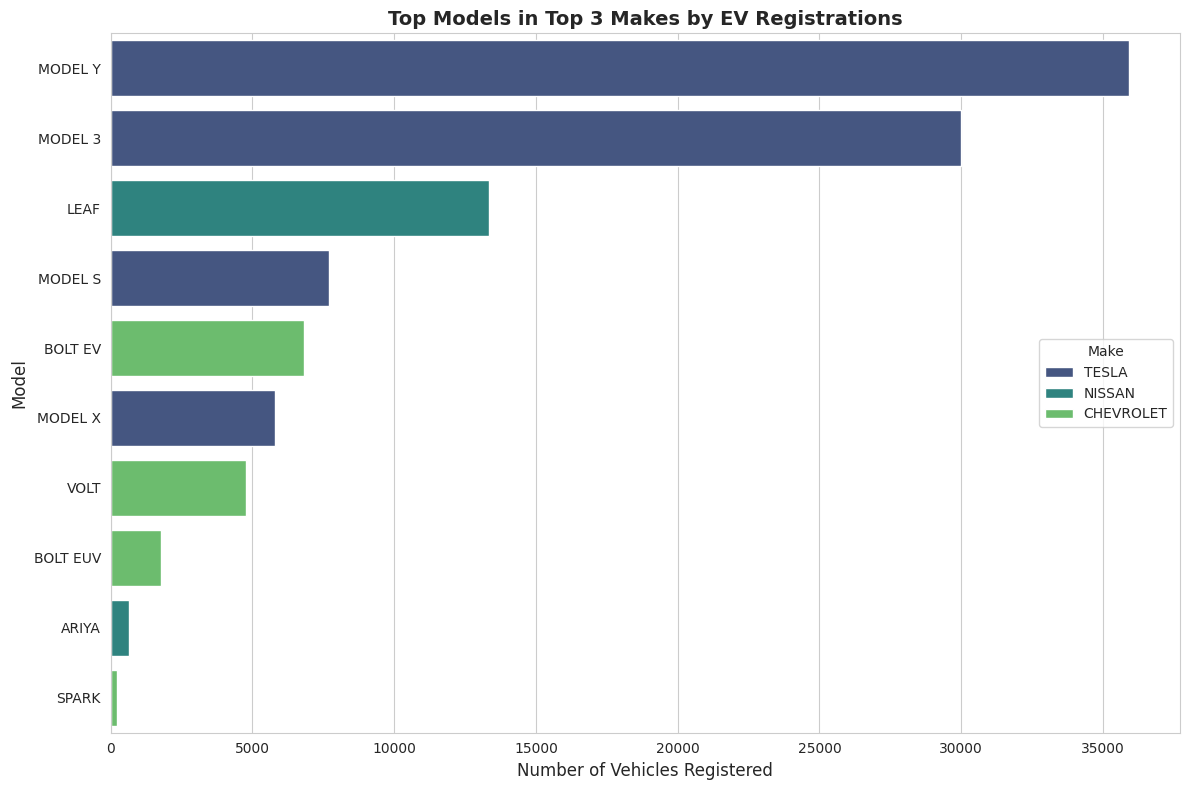

In [7]:
# Verify if 'Make' and 'Model' columns are available and contain data
if 'Make' in ev_data.columns and 'Model' in ev_data.columns:
    # Selecting the top 3 manufacturers by vehicle registrations
    top_3_makes = ev_make_distribution.head(3).index
    top_makes_data = ev_data[ev_data['Make'].isin(top_3_makes)]
    
    # Analyze distribution of EV models within these top manufacturers
    ev_model_distribution_top_makes = (top_makes_data.groupby(['Make', 'Model'])
                                       .size()
                                       .sort_values(ascending=False)
                                       .reset_index(name='Number of Vehicles'))
    
    # Limit visualization to the top 10 models for clarity
    top_models = ev_model_distribution_top_makes.head(10)
    
    # Set up the plot for the top models in the top 3 makes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Number of Vehicles', y='Model', hue='Make', data=top_models, palette="viridis")
    
    # Add title and labels
    plt.title('Top Models in Top 3 Makes by EV Registrations', fontsize=14, weight='bold')
    plt.xlabel('Number of Vehicles Registered', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    
    # Customize legend and layout
    plt.legend(title='Make', loc='center right')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'Make' and 'Model' are missing or contain no data.")

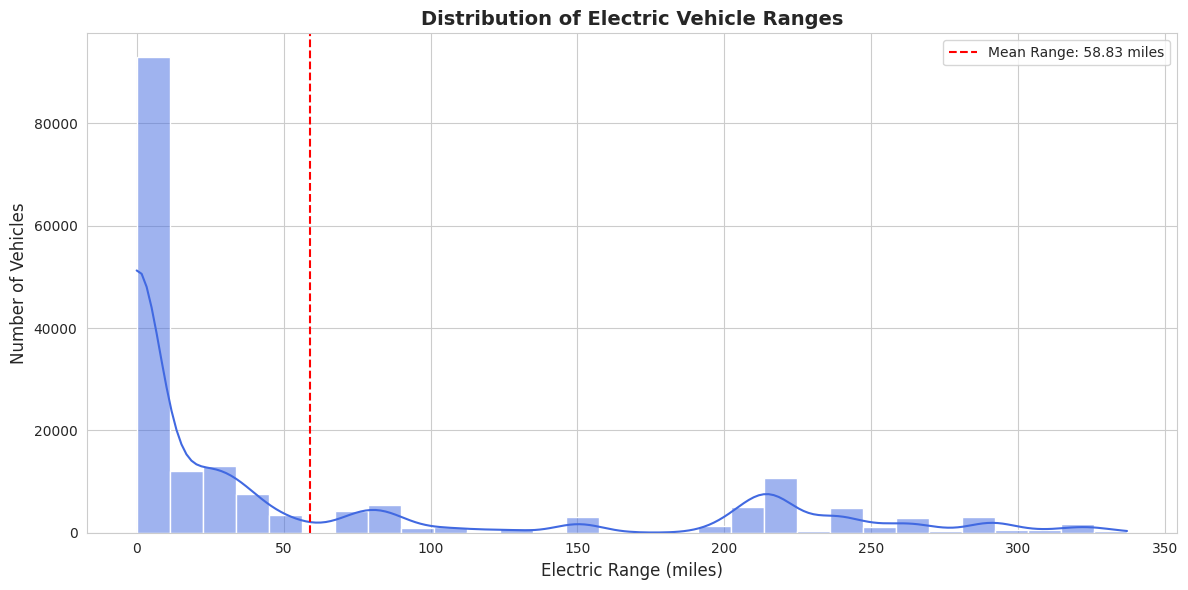

In [8]:
# Check if 'Electric Range' column exists and contains data
if 'Electric Range' in ev_data.columns and not ev_data['Electric Range'].isnull().all():
    # Set up the plot for the distribution of electric vehicle ranges
    plt.figure(figsize=(12, 6))
    sns.histplot(ev_data['Electric Range'], bins=30, kde=True, color='royalblue')
    
    # Add title and labels with improved formatting
    plt.title('Distribution of Electric Vehicle Ranges', fontsize=14, weight='bold')
    plt.xlabel('Electric Range (miles)', fontsize=12)
    plt.ylabel('Number of Vehicles', fontsize=12)
    
    # Calculate and display the mean electric range
    mean_range = ev_data['Electric Range'].mean()
    plt.axvline(mean_range, color='red', linestyle='--', label=f'Mean Range: {mean_range:.2f} miles')
    
    # Add legend
    plt.legend(loc='upper right')
    
    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("The 'Electric Range' column is missing or contains no data.")

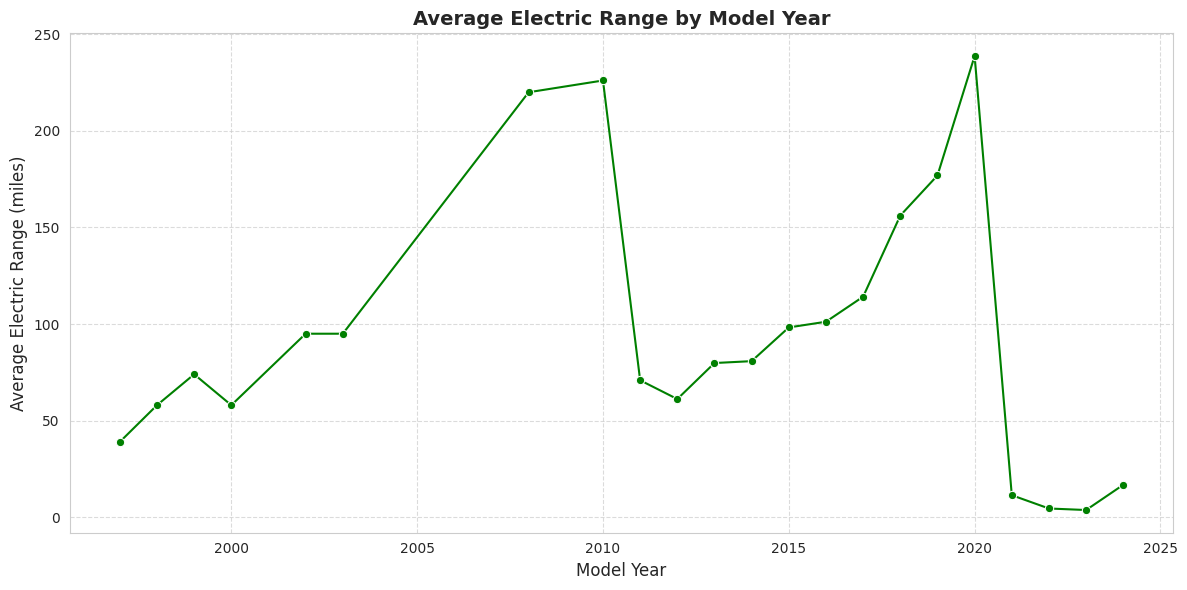

In [9]:
# Check if 'Model Year' and 'Electric Range' columns exist and contain data
if 'Model Year' in ev_data.columns and 'Electric Range' in ev_data.columns:
    # Calculate the average electric range by model year
    average_range_by_year = ev_data.groupby('Model Year')['Electric Range'].mean().reset_index()
    
    # Set up the plot for the average electric range by model year
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Model Year', y='Electric Range', data=average_range_by_year, marker='o', color='green')
    
    # Add title and labels with improved formatting
    plt.title('Average Electric Range by Model Year', fontsize=14, weight='bold')
    plt.xlabel('Model Year', fontsize=12)
    plt.ylabel('Average Electric Range (miles)', fontsize=12)
    
    # Add grid for easier reading of data points
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Display the plot
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'Model Year' and 'Electric Range' are missing or contain no data.")

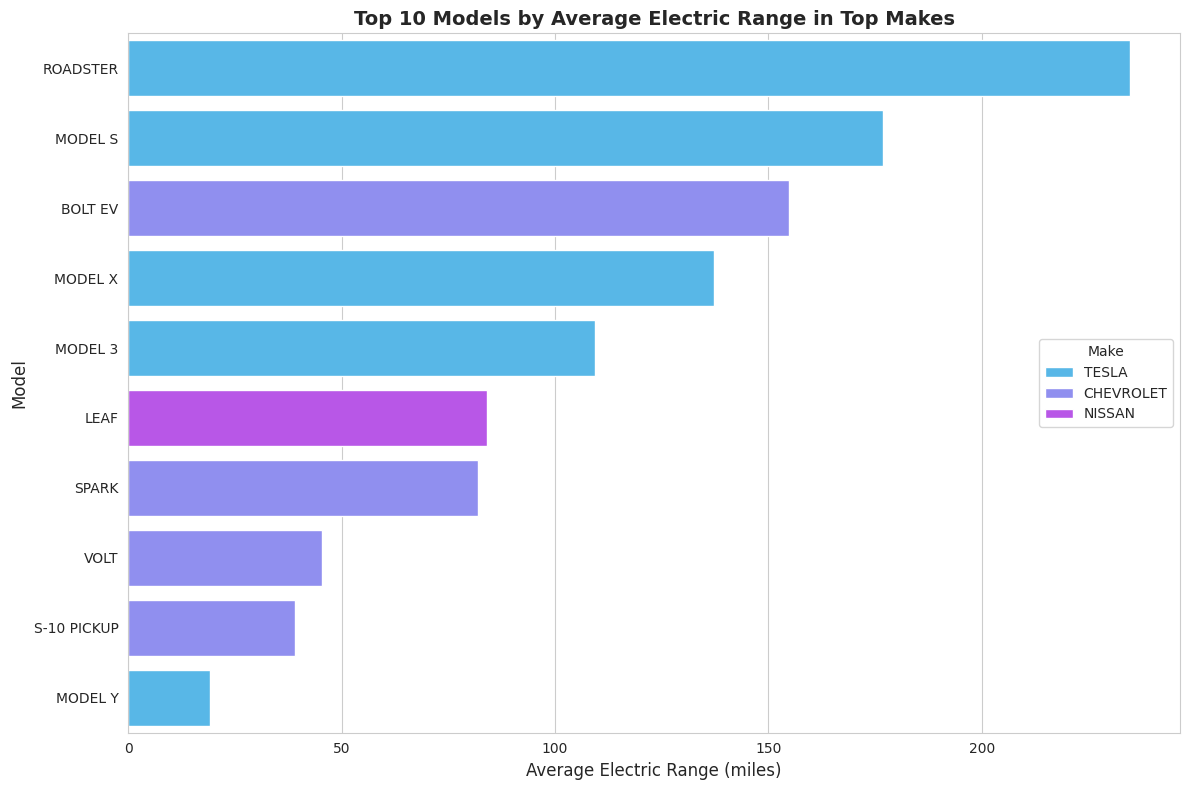

In [10]:
# Verify if 'Make', 'Model', and 'Electric Range' columns are present and contain data
if 'Make' in top_makes_data.columns and 'Model' in top_makes_data.columns and 'Electric Range' in top_makes_data.columns:
    # Calculate the average electric range by model within each make
    average_range_by_model = (top_makes_data.groupby(['Make', 'Model'])['Electric Range']
                              .mean()
                              .sort_values(ascending=False)
                              .reset_index())
    
    # Select the top 10 models with the highest average electric range
    top_range_models = average_range_by_model.head(10)
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Electric Range', y='Model', hue='Make', data=top_range_models, palette="cool")
    
    # Add title and labels with improved formatting
    plt.title('Top 10 Models by Average Electric Range in Top Makes', fontsize=14, weight='bold')
    plt.xlabel('Average Electric Range (miles)', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    
    # Customize legend and layout
    plt.legend(title='Make', loc='center right')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'Make', 'Model', and 'Electric Range' are missing or contain no data.")

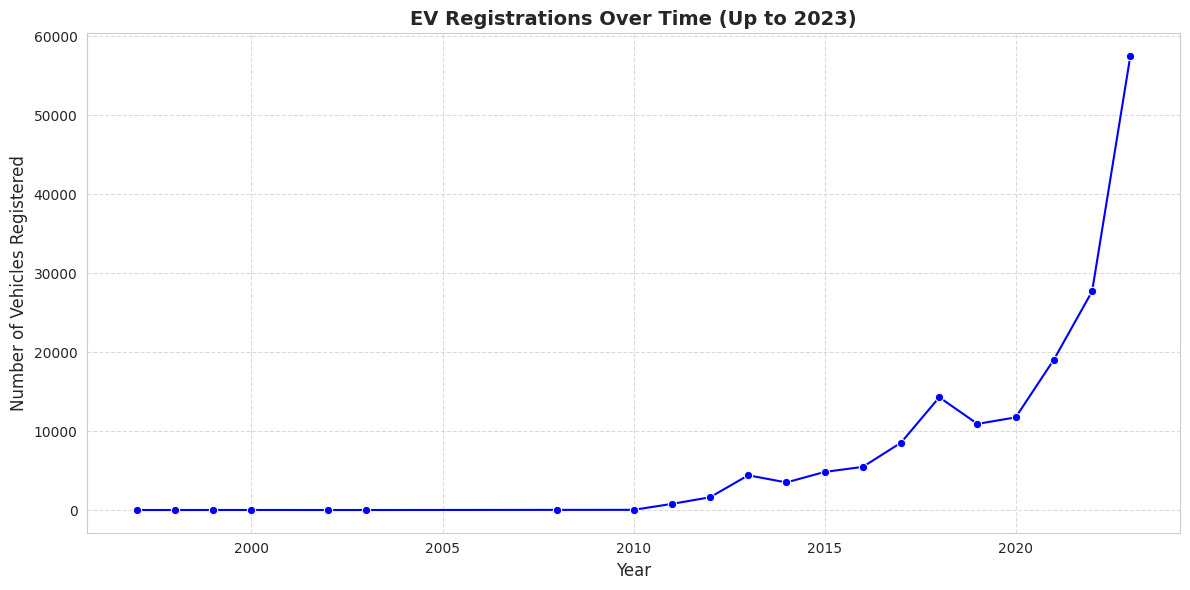

In [11]:
# Check if 'Model Year' is present
if 'Model Year' in ev_data.columns:
    # Aggregate EV registrations per year and filter up to 2023
    ev_registration_counts = ev_data['Model Year'].value_counts().sort_index()
    time_series_data = ev_registration_counts[ev_registration_counts.index <= 2023].rename_axis('Year').reset_index(name='Registrations')
    
    # Plot EV registrations up to 2023
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Year', y='Registrations', data=time_series_data, marker='o', color='blue')
    plt.title('EV Registrations Over Time (Up to 2023)', fontsize=14, weight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Vehicles Registered', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("The 'Model Year' column is missing or contains no data.")

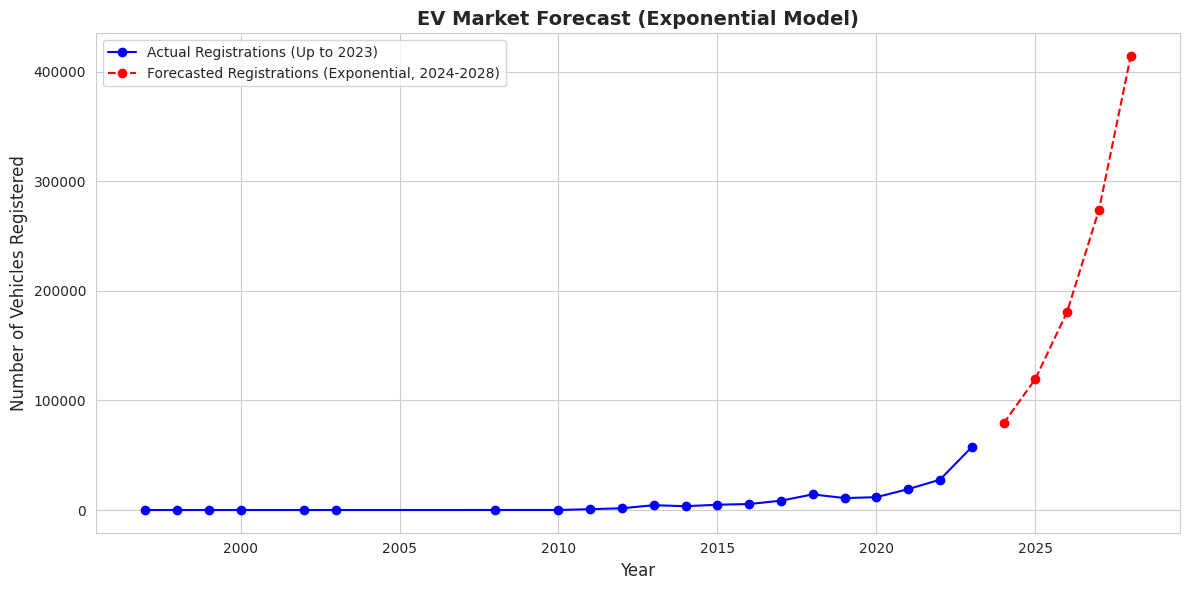

In [12]:
from scipy.optimize import curve_fit
import numpy as np

# Define exponential growth function
def exp_growth(x, a, b):
    return a * np.exp(b * x)

# Prepare data for curve fitting (up to 2023)
years = np.array(time_series_data['Year'])
registrations = np.array(time_series_data['Registrations'])

# Fit exponential model using data up to 2023
params, covariance = curve_fit(exp_growth, years - years.min(), registrations)

# Forecast future registrations from 2024 to 2028
future_years = np.arange(2024, 2029)
forecasted_values = exp_growth(future_years - years.min(), *params)

# Plot actual (up to 2023) vs forecasted values (2024-2028)
plt.figure(figsize=(12, 6))
plt.plot(years, registrations, 'bo-', label='Actual Registrations (Up to 2023)')
plt.plot(future_years, forecasted_values, 'ro--', label='Forecasted Registrations (Exponential, 2024-2028)')
plt.title('EV Market Forecast (Exponential Model)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Vehicles Registered', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/home/ff15-arkhe/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ff15-arkhe/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40376D+00    |proj g|=  1.51250D+00

At iterate    5    f=  3.99301D+00    |proj g|=  8.96561D-03

At iterate   10    f=  3.98557D+00    |proj g|=  7.31240D-04

At iterate   15    f=  3.98506D+00    |proj g|=  1.40596D-04

At iterate   20    f=  3.98504D+00    |proj g|=  1.55042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     35      1     0     0   1.550D-04   3.985D+00
  F =   3.9850368587389240     

CONVERG

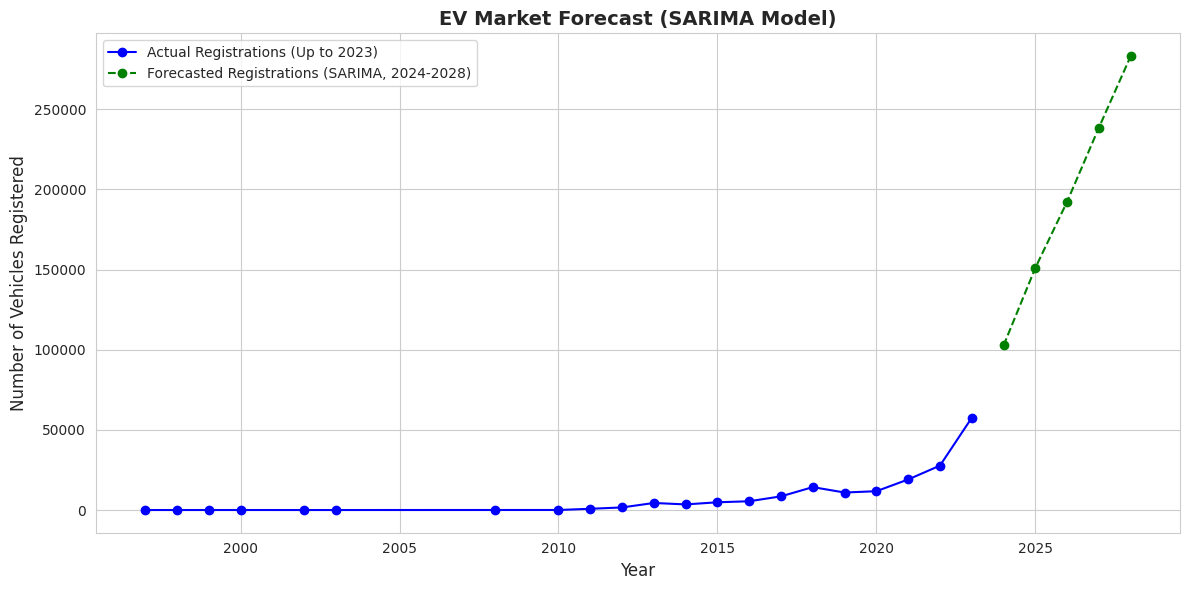

SARIMA Forecasted Values (2024-2028): {2024: 102622.86536500827, 2025: 151026.93545715435, 2026: 192348.33202280835, 2027: 238546.34227250732, 2028: 283158.1993056945}


In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set up SARIMA model using data up to 2023
model = SARIMAX(time_series_data['Registrations'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = model.fit()

# Forecast EV registrations for 2024-2028
forecast_sarima = sarima_results.get_forecast(steps=5)
forecasted_sarima_values = forecast_sarima.predicted_mean
forecast_index = np.arange(2024, 2029)

# Plot actual vs SARIMA forecasted values (up to 2023, forecasted for 2024-2028)
plt.figure(figsize=(12, 6))
plt.plot(years, registrations, 'bo-', label='Actual Registrations (Up to 2023)')
plt.plot(forecast_index, forecasted_sarima_values, 'go--', label='Forecasted Registrations (SARIMA, 2024-2028)')
plt.title('EV Market Forecast (SARIMA Model)', fontsize=14, weight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Vehicles Registered', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print SARIMA forecasted values for reference
forecasted_sarima_dict = dict(zip(forecast_index, forecasted_sarima_values))
print("SARIMA Forecasted Values (2024-2028):", forecasted_sarima_dict)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40376D+00    |proj g|=  1.51250D+00

At iterate    5    f=  3.99301D+00    |proj g|=  8.96561D-03

At iterate   10    f=  3.98557D+00    |proj g|=  7.31240D-04

At iterate   15    f=  3.98506D+00    |proj g|=  1.40596D-04

At iterate   20    f=  3.98504D+00    |proj g|=  1.55042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     35      1     0     0   1.550D-04   3.985D+00
  F =   3.9850368587389240     

CONVERG

/home/ff15-arkhe/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ff15-arkhe/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


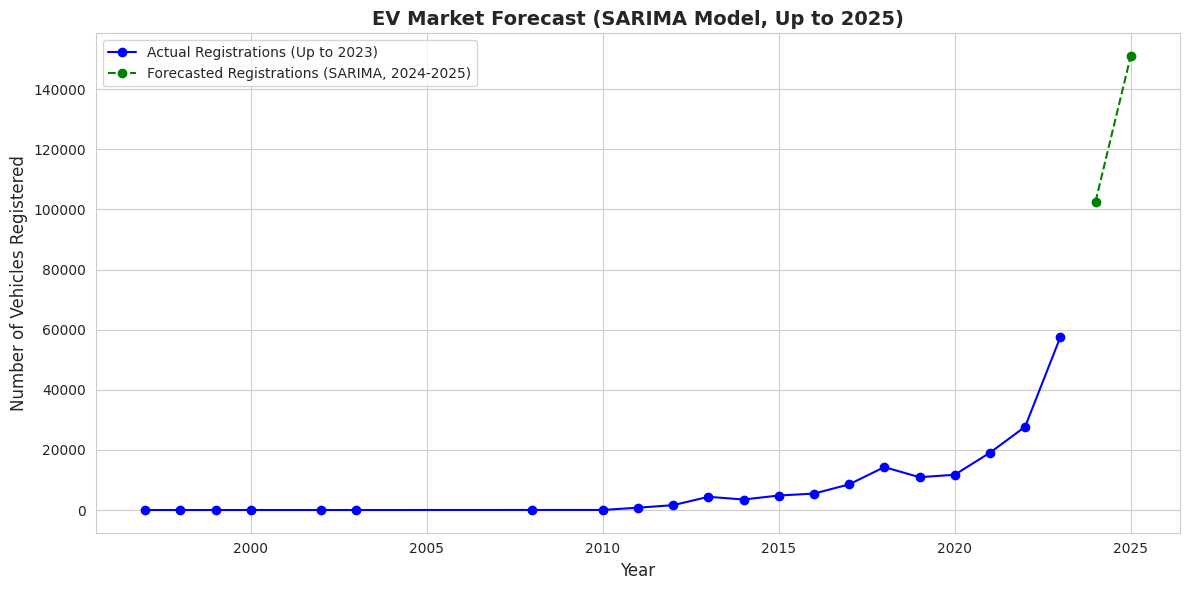

SARIMA Forecasted Values (2024-2025): {2024: 102622.86536500827, 2025: 151026.93545715435}


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

# Ensure data includes only completed years up to 2023
if 'Model Year' in ev_data.columns:
    ev_registration_counts = ev_data['Model Year'].value_counts().sort_index()
    time_series_data = ev_registration_counts[ev_registration_counts.index <= 2023].rename_axis('Year').reset_index(name='Registrations')

    # Set up the SARIMA model using data up to 2023
    model = SARIMAX(time_series_data['Registrations'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_results = model.fit()

    # Forecast EV registrations for 2024 and 2025 only
    forecast_sarima = sarima_results.get_forecast(steps=2)
    forecasted_sarima_values = forecast_sarima.predicted_mean
    forecast_index = np.arange(2024, 2026)  # Represents years 2024 and 2025

    # Plot actual data up to 2023 and SARIMA forecast for 2024-2025
    years = time_series_data['Year']
    registrations = time_series_data['Registrations']
    plt.figure(figsize=(12, 6))
    plt.plot(years, registrations, 'bo-', label='Actual Registrations (Up to 2023)')
    plt.plot(forecast_index, forecasted_sarima_values, 'go--', label='Forecasted Registrations (SARIMA, 2024-2025)')
    plt.title('EV Market Forecast (SARIMA Model, Up to 2025)', fontsize=14, weight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Vehicles Registered', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print SARIMA forecasted values for reference
    forecasted_sarima_dict = dict(zip(forecast_index, forecasted_sarima_values))
    print("SARIMA Forecasted Values (2024-2025):", forecasted_sarima_dict)
else:
    print("The 'Model Year' column is missing or contains no data.")
